<a href="https://colab.research.google.com/github/brdeleon/flagging_loans_shapley_values/blob/main/flagging_loans_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flagging Loans
## Imports

In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.4 MB/s eta 0:00:00


In [2]:
pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00


In [3]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.9 MB/s eta 0:00:00


In [5]:
import warnings
warnings.filterwarnings("ignore")

import joblib as jb
from joblib import dump, load

import os
import shap
import math
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import kaleido
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE, RFECV

from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, brier_score_loss, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, CondensedNearestNeighbour 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as ltb
from lightgbm import LGBMClassifier
import catboost as ctb
from catboost import CatBoostClassifier

seed = np.random.seed(42)

### Importing Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/loan_data/df.csv')

In [8]:
# Previewing first 5 rows and last 5 rows of the dataset
df.head().append(df.tail())

,loanKey,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,...,age,gender,bad_flag,rep_loan_year,rep_loan_month,rep_loan_day,first_loan_year,first_loan_month,first_loan_day,days_between_rep_and_first_loan
0,708382,0.0,0.0,0.0,3.0,region_6,6,0,0,10,...,21.0,0,0,2016,10,6,2015,11,13,328
1,406305,1.0,0.0,0.0,0.0,region_6,6,0,0,6,...,20.0,0,0,2016,3,26,2015,9,28,180
2,779736,0.0,0.0,0.0,2.0,region_1,6,0,0,0,...,19.0,0,0,2016,10,30,2015,12,21,314
3,556376,0.0,0.0,0.0,1.0,region_6,14,0,0,4,...,21.0,0,0,2016,6,29,2015,6,30,365
4,266968,0.0,0.0,0.0,0.0,region_5,22,0,3,0,...,33.0,0,0,2015,12,1,2015,8,3,120
4126,533637,0.0,0.0,0.0,0.0,region_5,7,0,0,1,...,26.0,0,0,2016,6,11,2016,5,17,25
4127,596156,0.0,0.0,0.0,1.0,region_2,12,0,0,4,...,38.0,0,1,2016,8,6,2016,3,11,148
4128,645359,0.0,0.0,0.0,1.0,region_2,12,0,0,4,...,21.0,0,0,2016,9,5,2016,4,30,128
4129,730681,0.0,0.0,0.0,0.0,region_6,7,0,0,4,...,35.0,0,0,2016,10,14,2016,5,20,147
4130,521420,2.0,2.0,0.0,0.0,region_4,12,0,0,6,...,25.0,0,1,2016,6,2,2015,12,8,177


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4131 entries, 0 to 4130
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   loanKey                          4131 non-null   int64  
 1   dpd_5_cnt                        4131 non-null   float64
 2   dpd_15_cnt                       4131 non-null   float64
 3   dpd_30_cnt                       4131 non-null   float64
 4   close_loans_cnt                  4131 non-null   float64
 5   federal_district_nm              4131 non-null   object 
 6   TraderKey                        4131 non-null   int64  
 7   payment_type_0                   4131 non-null   int64  
 8   payment_type_1                   4131 non-null   int64  
 9   payment_type_2                   4131 non-null   int64  
 10  payment_type_3                   4131 non-null   int64  
 11  payment_type_4                   4131 non-null   int64  
 12  past_billings_cnt   

## Modeling

### Evaluation Function

In [10]:
# Defining an evaluation classification function for automation and evaluating subsequent models
def evaluate_classification(model, X_train, X_test, y_train, y_test, classes=None, 
                            normalize='true', cmap='Reds', label=''):
    
    """Input a model, training data and validation data to return sklearn metrics
        - Classification Report for training and validation 
        - PR AUC Score for training and validation 
        - Confusion Matrix for training and validation 
        - ROC Curve for training and validation
        - PR Curve for training and validation
        
        Args:
        model: instantiated classifier (ex: LogisticRegression = log_reg)
        X_train: train_test_split & preprocessed
        X_test: train_test_split 
        y_train: train_test_split & preprocessed
        y_test: train_test_split 
        label: optional label for type of classifier 
    """
    # retrieve predictions for train and validation data 
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # retrieve probabilites for train and validation data 
    y_hat_train = model.predict_proba(X_train)
    y_hat_test = model.predict_proba(X_test)
    
    # retrieve probabilities for the positive class
    pos_probs_train = y_hat_train[:, 1]
    pos_probs_test = y_hat_test[:, 1]
    
    # print training classification report 
    header = label + " Classification Report Training "
    dashes = "---" * 20
    print(dashes, header, dashes, sep='\n')
    print(classification_report(y_train, y_pred_train, target_names=classes))
    
    # Display training figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_train, y=y_train, display_labels=classes, cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix - Training')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')    
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_train, y_train, name=label, ax=axes[1])
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic - Training')

    # Plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Training')
    fig.tight_layout()
    plt.show()

    # print validation classification report 
    header_ = label + "Classification Report Test"
    print(dashes, header_, dashes, sep='\n')
    print(classification_report(y_test, y_pred_test, target_names=classes))
    
    # display validation figures 
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    
    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_test, y=y_test, display_labels=classes, cmap=cmap, ax=axes[0])
    axes[0].set(title='Confusion Matrix - Test')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=label, ax=axes[1])
    axes[1].plot([0,1], [0,1], ls=':', label='No Skill')
    axes[1].grid()
    axes[1].set_title('Receiving Operator Characteristic - Test')

    # Plot Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[2], name=label)
    # y axis is Precision
    axes[2].set_ylabel('Precision')
    # x axis is Recall
    axes[2].set_xlabel('Recall')
    axes[2].set_title('Precision-Recall AUC Test')
    plt.legend()
    fig.tight_layout()
    plt.show()

### Data Split

Split data into training, validation, and test sets. Training set is used to train machine learning model, training set is used to evaluate performance of models during training, and the test set is used to evaluate final performance. It is important that the class distribution is preserved across the sets. We specify for data to be split in a stratified fashion, using the class labels. Using stratification helps ensure that the proportion of the target class in each split is close to that of the original data for a fair comparison. (Data School)

In [11]:
# Defining x and y for data split
X = df.drop('bad_flag', axis=1)
y = df['bad_flag']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Pipeline Building

To avoid data leakage we will build a model using a pipeline and columntransformers. Using pipeline and columntransformer helps prevent data leakage by creating a clear separation between the preprocessing and modeling steps. We are able to apply different preprocessing steps to specific features in the data with columntransformers.

We will standardize so that each variable contributes more equally to the analysis. Variables represent very different information and we want to take into account the properties of each column. We will compare scaling methods to decide which is more appropriate for each column. Our columntransformer will contain a subpipeline for each different preprocessing step.

In [12]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.7 MB/s eta 0:00:00


In [13]:
from category_encoders import TargetEncoder

In [14]:
# create a sub-pipeline for the columntransformer 
cat_subpipe = Pipeline([                 
    ('te', TargetEncoder(handle_unknown='value', return_df=True))
])

In [15]:
# Create a column transformer for one hot encoding the 'federal_district_nm' column
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_subpipe, ['federal_district_nm'])
        ],
        remainder='passthrough'
        )

In [16]:
# Create the XGBoost model with the preprocessor included in the Pipeline
xgbc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
    ])

In [17]:
# Fit pipeline
xgbc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['federal_district_nm'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=F...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
XGBClassifier Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2974
           1       1.00      1.00      1.00       330

    accuracy                           1.00      3304
   macro avg       1.00      1.00      1.00      3304
weighted avg       1.00      1.00      1.00      3304



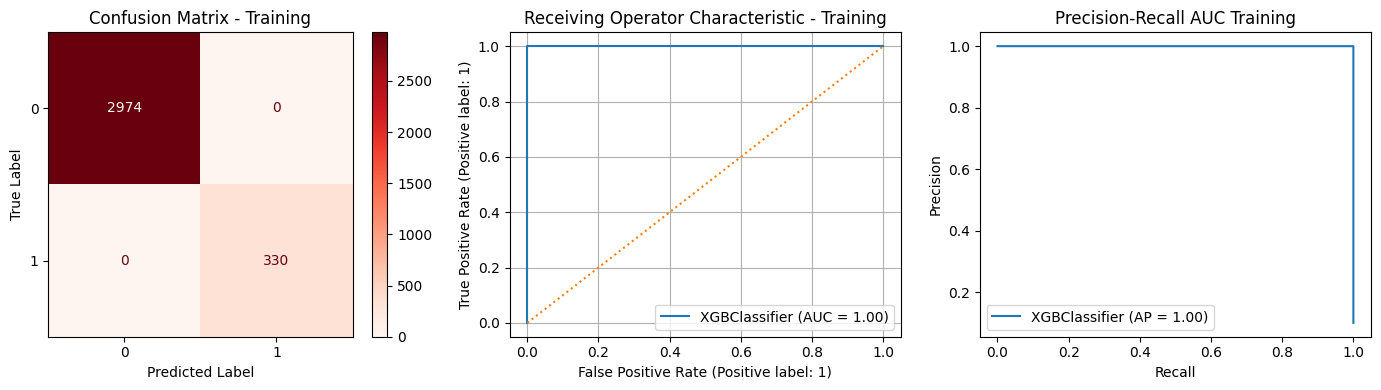

------------------------------------------------------------
XGBClassifierClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       745
           1       0.35      0.15      0.21        82

    accuracy                           0.89       827
   macro avg       0.63      0.56      0.57       827
weighted avg       0.86      0.89      0.87       827



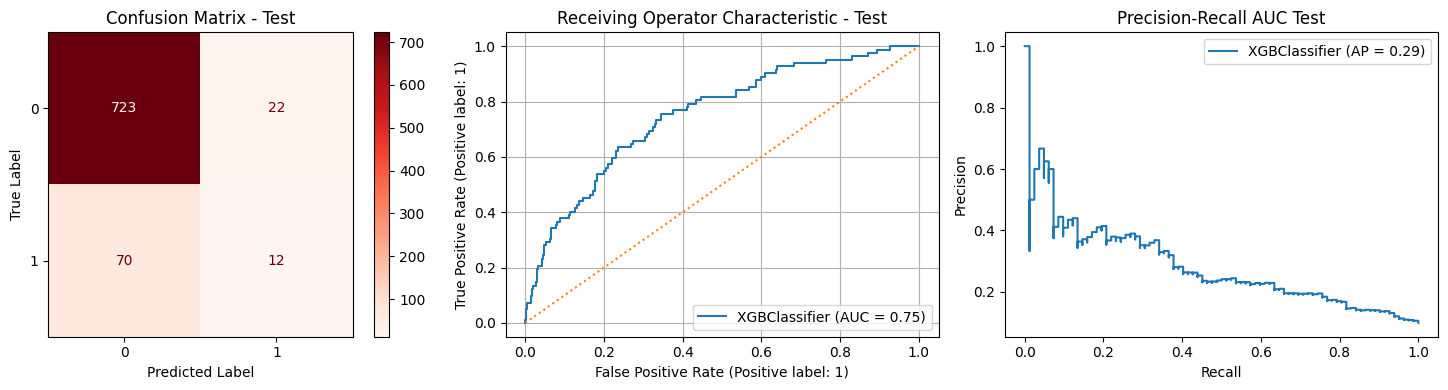

In [18]:
# Classification report using function 
evaluate_classification(xgbc_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='XGBClassifier')

Next: We will add another technique to help the model with the imbalanced data.

### Sampling Methods using imbPipeline

In [19]:
imblearn_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

In [20]:
imblearn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['federal_district_nm'])])),
                ('sampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynod...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
Over Sampled XGBClassifier Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2974
           1       1.00      1.00      1.00       330

    accuracy                           1.00      3304
   macro avg       1.00      1.00      1.00      3304
weighted avg       1.00      1.00      1.00      3304



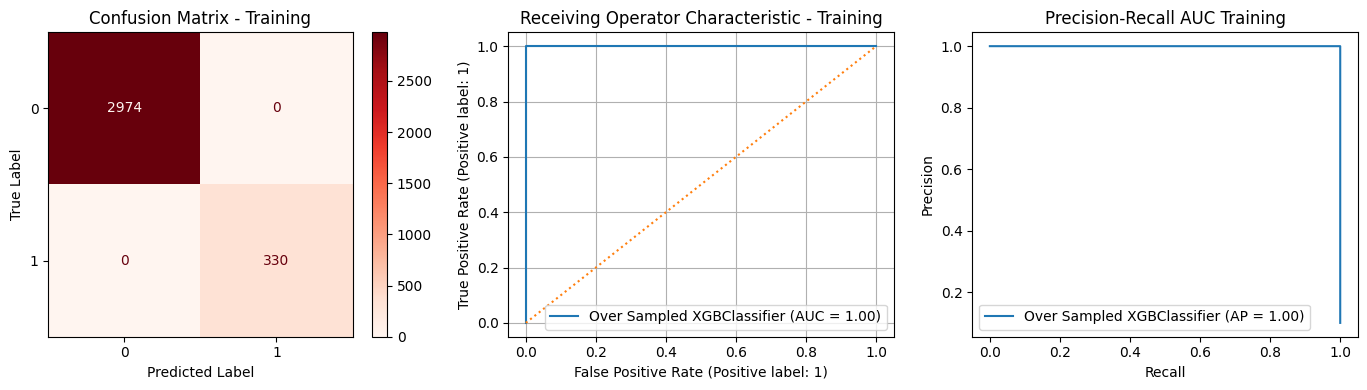

------------------------------------------------------------
Over Sampled XGBClassifierClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       745
           1       0.30      0.27      0.28        82

    accuracy                           0.87       827
   macro avg       0.61      0.60      0.60       827
weighted avg       0.86      0.87      0.86       827



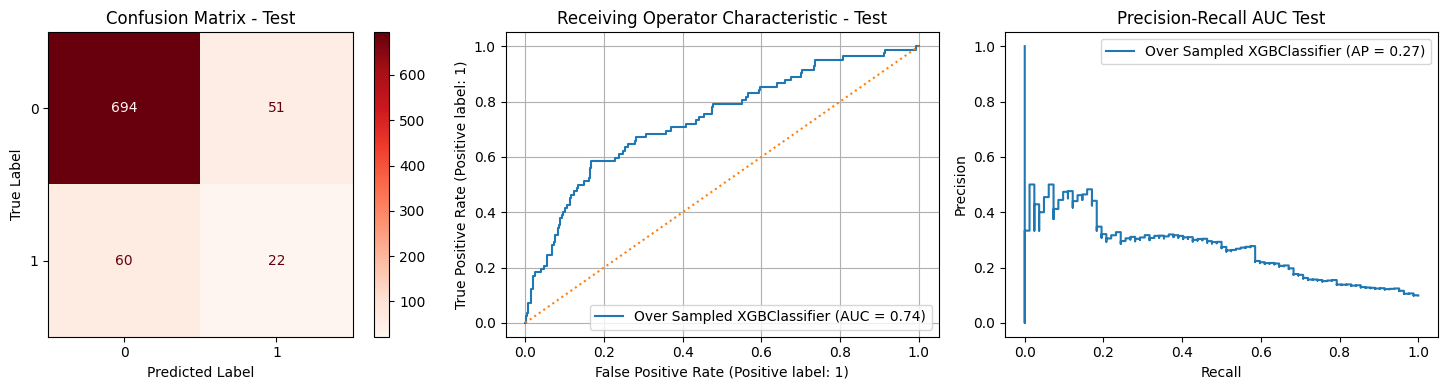

In [21]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Over Sampled XGBClassifier')

In [22]:
imblearn_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

In [23]:
imblearn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['federal_district_nm'])])),
                ('sampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_byno...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
Under Sampled XGBClassifier Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.70      0.83      2974
           1       0.27      1.00      0.43       330

    accuracy                           0.73      3304
   macro avg       0.64      0.85      0.63      3304
weighted avg       0.93      0.73      0.79      3304



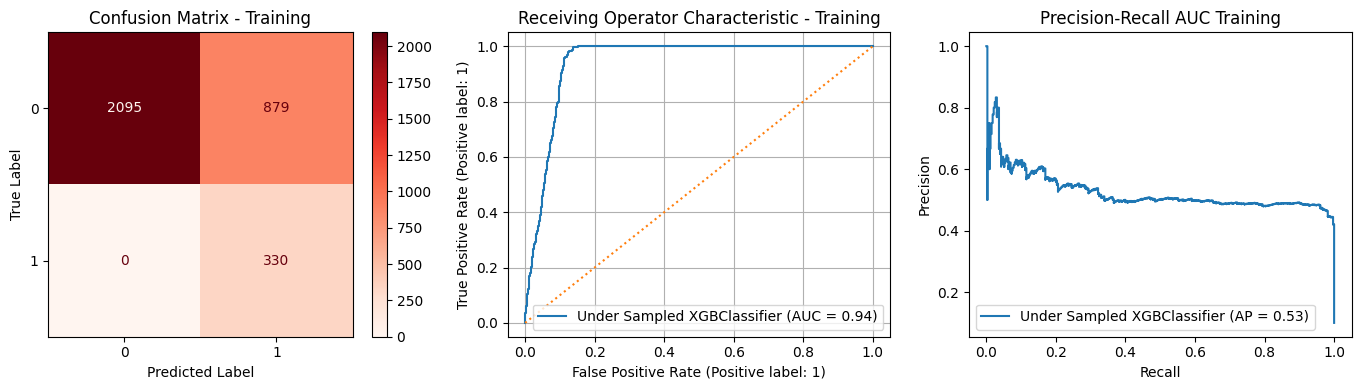

------------------------------------------------------------
Under Sampled XGBClassifierClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       745
           1       0.21      0.76      0.33        82

    accuracy                           0.69       827
   macro avg       0.59      0.72      0.56       827
weighted avg       0.89      0.69      0.75       827



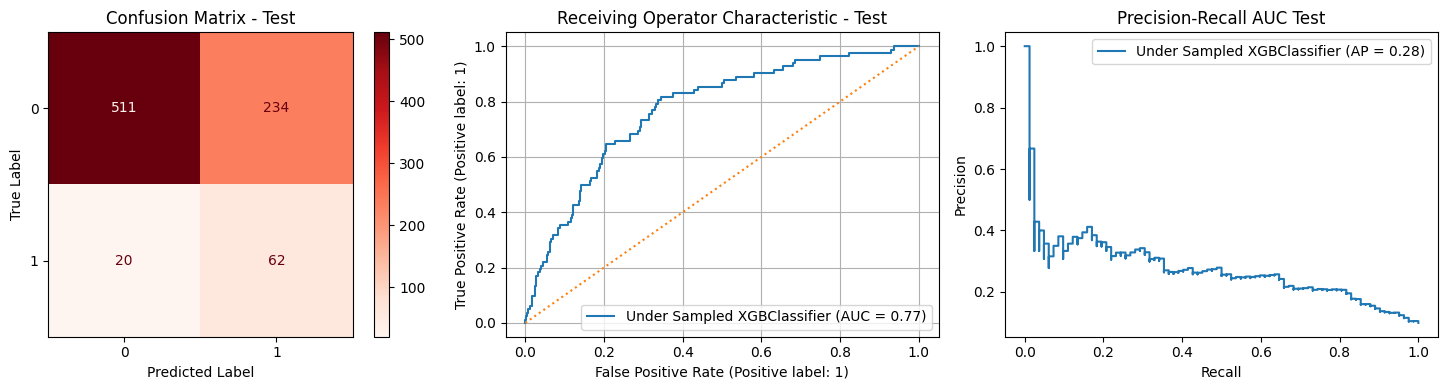

In [24]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under Sampled XGBClassifier')

In [25]:
imblearn_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('oversampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

In [26]:
imblearn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['federal_district_nm'])])),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('oversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('classifier',
                 XGBClassifier(bas...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

------------------------------------------------------------
Under Sampled Random Forest Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      2974
           1       0.41      1.00      0.58       330

    accuracy                           0.86      3304
   macro avg       0.71      0.92      0.75      3304
weighted avg       0.94      0.86      0.88      3304



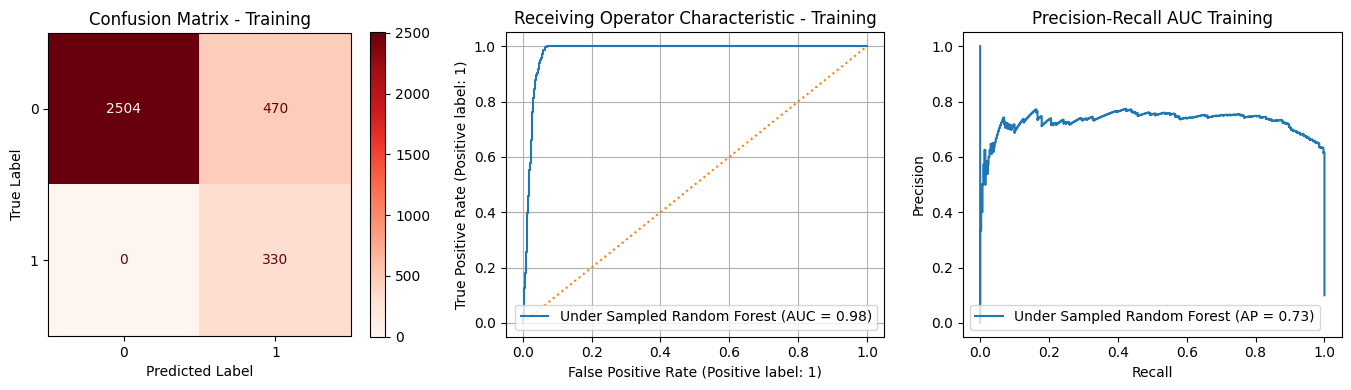

------------------------------------------------------------
Under Sampled Random ForestClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       745
           1       0.23      0.57      0.33        82

    accuracy                           0.77       827
   macro avg       0.59      0.68      0.60       827
weighted avg       0.87      0.77      0.81       827



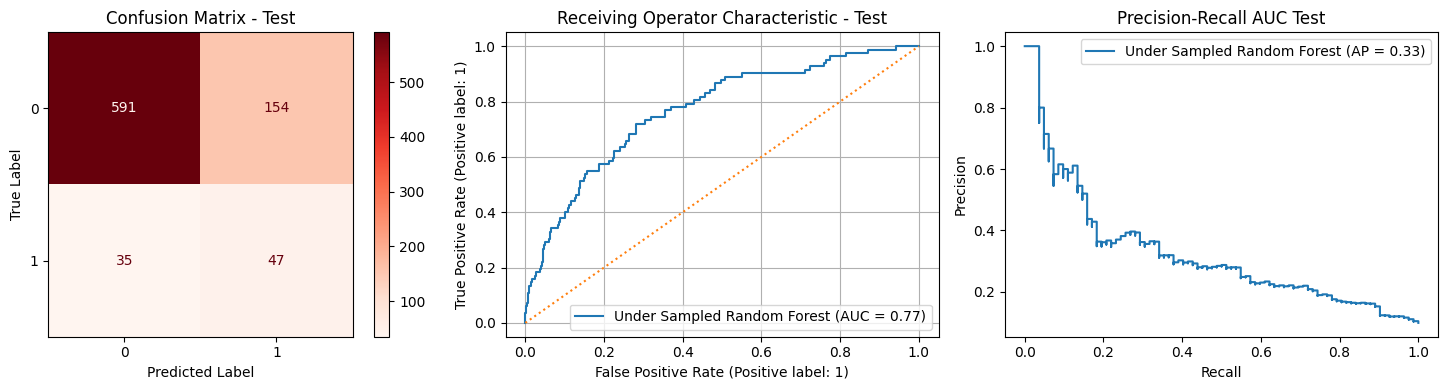

In [27]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under Sampled Random Forest')

### Random Forest

In [28]:
imblearn_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    
    ('sampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42)
    )
])

In [29]:
imblearn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['federal_district_nm'])])),
                ('sampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('classifier', RandomForestClassifier(random_state=42))])

------------------------------------------------------------
Over Sampled Random Forest Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2974
           1       1.00      1.00      1.00       330

    accuracy                           1.00      3304
   macro avg       1.00      1.00      1.00      3304
weighted avg       1.00      1.00      1.00      3304



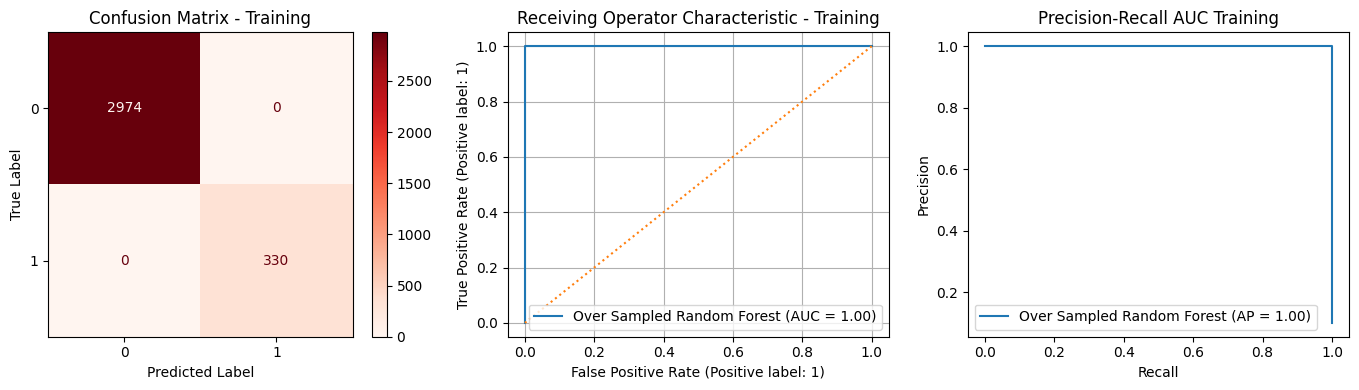

------------------------------------------------------------
Over Sampled Random ForestClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       745
           1       0.41      0.16      0.23        82

    accuracy                           0.89       827
   macro avg       0.66      0.57      0.59       827
weighted avg       0.86      0.89      0.87       827



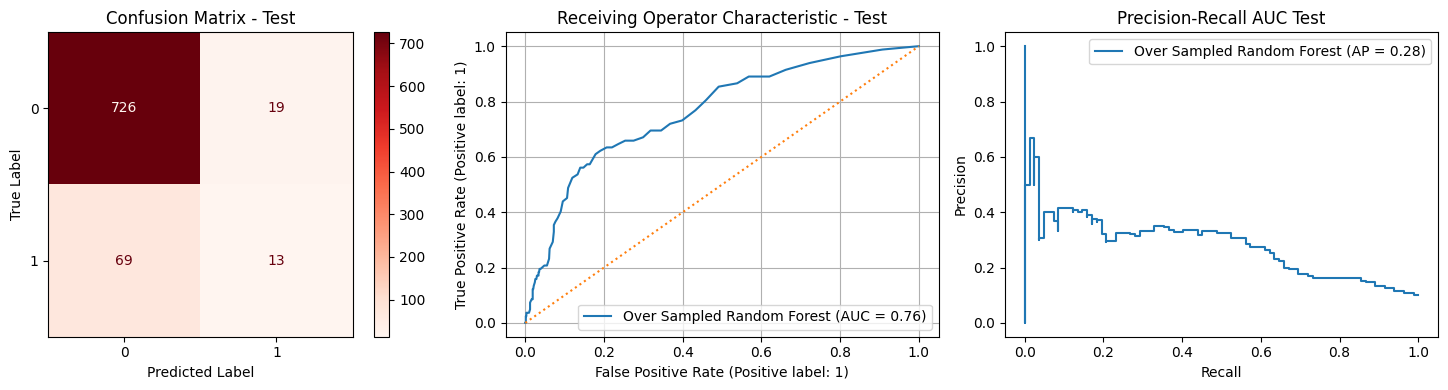

In [30]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Over Sampled Random Forest')

In [31]:
imblearn_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [32]:
imblearn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['federal_district_nm'])])),
                ('sampler',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy='majority')),
                ('classifier', RandomForestClassifier(random_state=42))])

------------------------------------------------------------
Under Sampled Random Forest Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.74      0.85      2974
           1       0.30      1.00      0.46       330

    accuracy                           0.76      3304
   macro avg       0.65      0.87      0.65      3304
weighted avg       0.93      0.76      0.81      3304



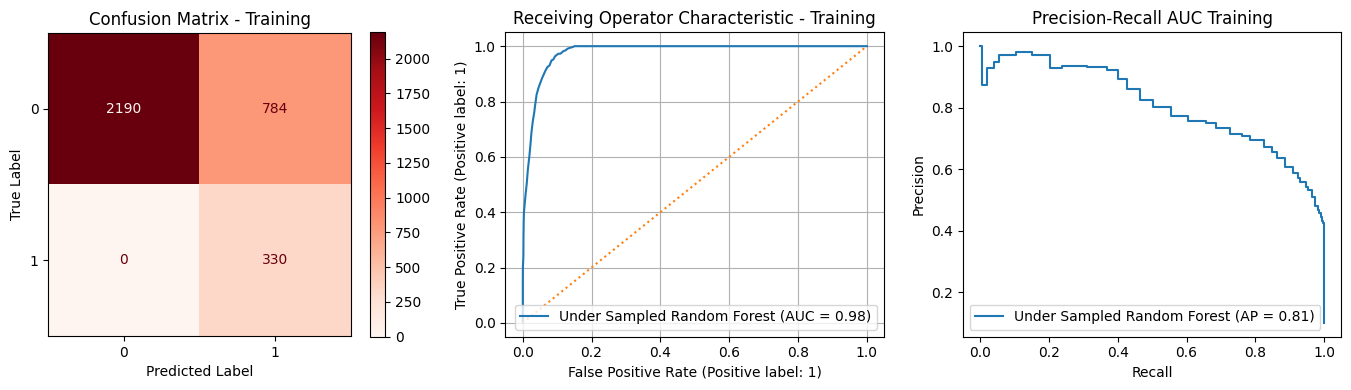

------------------------------------------------------------
Under Sampled Random ForestClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       745
           1       0.20      0.71      0.31        82

    accuracy                           0.69       827
   macro avg       0.58      0.70      0.56       827
weighted avg       0.88      0.69      0.75       827



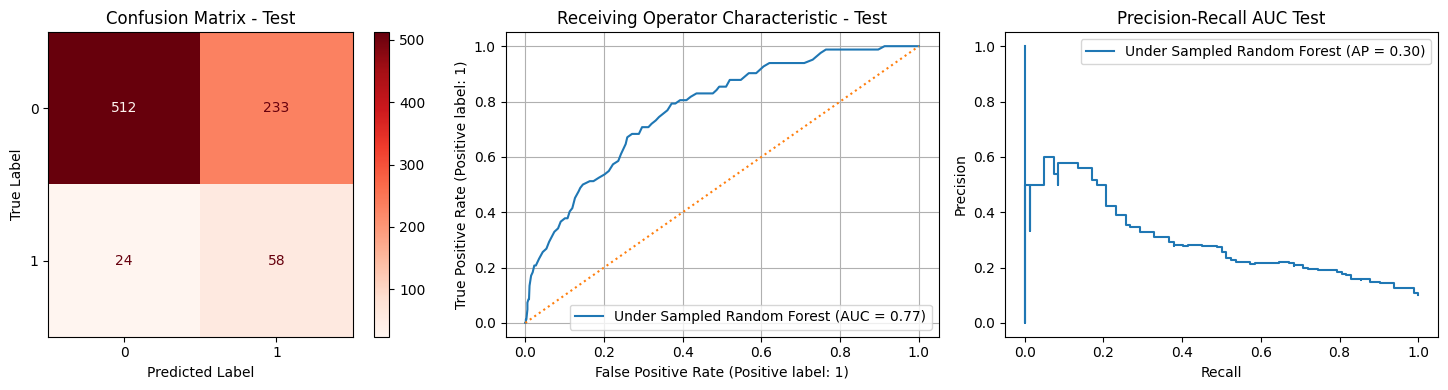

In [33]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under Sampled Random Forest')

In [34]:
imblearn_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('oversampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [35]:
imblearn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['federal_district_nm'])])),
                ('undersampler',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('oversampler',
                 RandomOverSampler(random_state=42,
                                   sampling_strategy='minority')),
                ('classifier', RandomForestClassifier(random_state=42))])

------------------------------------------------------------
Under and Over Sampled Random Forest Classification Report Training 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.93      2974
           1       0.45      1.00      0.62       330

    accuracy                           0.88      3304
   macro avg       0.72      0.93      0.77      3304
weighted avg       0.94      0.88      0.90      3304



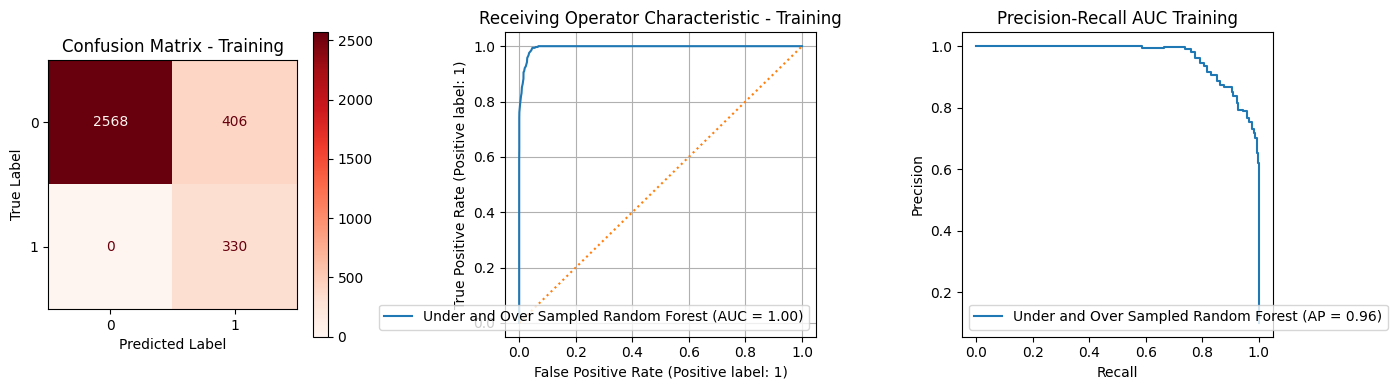

------------------------------------------------------------
Under and Over Sampled Random ForestClassification Report Test
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       745
           1       0.27      0.62      0.38        82

    accuracy                           0.80       827
   macro avg       0.61      0.72      0.63       827
weighted avg       0.88      0.80      0.83       827



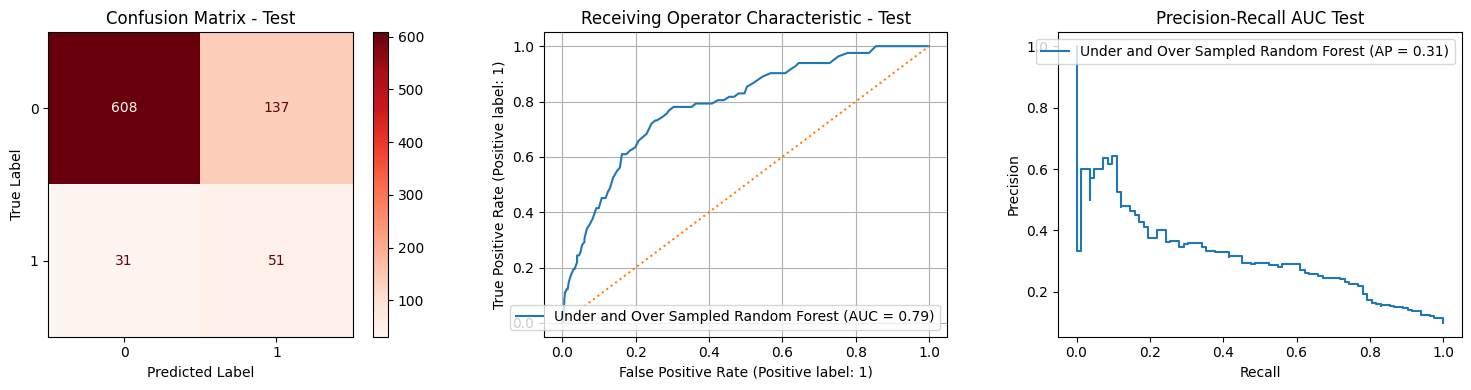

In [36]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under and Over Sampled Random Forest')

In [37]:
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [5, 10],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

In [38]:
# Pipeline with gridsearch
grid_search = GridSearchCV(estimator=imblearn_pipeline, 
                           param_grid=param_grid, 
                           # settting cross-validation splitting strategy to repeat stratified k-fold 3 times
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           # setting true so train scores along with test scores are returned
                           return_train_score=True, 
                           # setting scoring method to macro recall score
                           scoring='recall_macro', 
                           # setting to -1 so all cores on our CPU are used to cut down on time it takes to run
                           n_jobs=-1,
                           # setting to 1 will provide us with additional messages about running time 
                           verbose=1,
                           # set for error to be raised to help debug
                           error_score='raise')

In [39]:
# Fit grid search
#grid_search.fit(X_train, y_train)

In [40]:
# Return best performing parameters
# print(f"Best Parameters: {grid_search.best_params_}\n")

In [41]:
# classification report using function 
evaluate_classification(grid_search,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Random Forest GS')

NotFittedError: ignored

In [ ]:
# Define the column transformer
ct = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(), ['federal_district_nm'])
    ],
    remainder='passthrough'
    )

)

In [ ]:
subpipe_cat = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
])

In [ ]:
# creating columntransformer as 'CT'
# columntransformer will one hot encode all non np.number dtypes
# remainder data will pass through without transformation, instead of being dropped
CT = ColumnTransformer(transformers=[
     ('subpipe_cat', subpipe_cat, make_column_selector(dtype_include=object))], remainder='passthrough')

In [ ]:
# Define the under and over samplers
rus = RandomUnderSampler(sampling_strategy=0.5, 
                         random_state=42)
ros = RandomOverSampler(sampling_strategy='minority', 
                        random_state=42)

# Define the random forest classifier
rf = RandomForestClassifier(max_depth=10, 
                            min_samples_split=10, 
                            n_estimators=300, 
                            max_features='sqrt', 
                            class_weight='balanced_subsample', 
                            random_state=42)

In [ ]:
# Define the pipeline
final_pipeline = imbPipeline(steps=[
    ('CT', CT), 
    ('rus', rus), 
    ('ros', ros), 
    ('rf', rf)])

In [ ]:
# Fit the pipeline
final_pipeline.fit(X_train, y_train)

In [ ]:
# Classification report using function 
evaluate_classification(final_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under and Over Sampled Random Forest')

### Final Test

In [ ]:
# Use the final test set to evaluate the pipeline
y_pred = final_pipeline.predict(X_test)
recall_test = recall_score(y_test, y_pred, average='macro')
print("Test macro recall: ", recall_test)

In [ ]:
# from sklearn documentation
# number of times a feature is randomly shuffled specified to: 30
features = permutation_importance(final_pipeline, 
                                 X_test, 
                                 y_test, 
                                 n_repeats=30, 
                                 scoring='recall', 
                                 random_state=42)

In [ ]:
# from sklearn documentation
# probing which features are most predictive
for i in features.importances_mean.argsort()[::-1]:
     if features.importances_mean[i] - 2 * features.importances_std[i] > 0:
         print(f"{X_test.columns[i]:<8}"
               f"{features.importances_mean[i]:.3f}"
               f" +/- {features.importances_std[i]:.3f}")

In [ ]:
import shap

In [ ]:
# function to turn series to dataframe
def series_to_dataframe(series):
    return pd.DataFrame(series)

# Function Transformer
series_FT = FunctionTransformer(series_to_dataframe)

In [ ]:
cat_cols = ["federal_district_nm"]

In [ ]:
# instantiating the one hot encoder
ohe = OneHotEncoder(handle_unknown='ignore')

In [ ]:
# pipeline to one hot encode dataframe
ohe_pipe = Pipeline(steps=[
    ('to_df', series_FT),
    ('ohe', ohe),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

In [ ]:
# Define the column transformer
ct = ColumnTransformer(transformers=[
    ('ohe_pipe', ohe_pipe, cat_cols)
    ], remainder='passthrough')

# Define the pipeline
final_pipeline = imbPipeline(steps=[
     ("ct", ct),
     ("rus", RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
     ("ros", RandomOverSampler(random_state=42, sampling_strategy='minority')),
     ("rf", RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=10,
                                    class_weight='balanced_subsample', random_state=42))
    ])

# Fit the pipeline to the training set
final_pipeline.fit(X_train, y_train)

In [ ]:
# Transform the test data using the fitted pipeline
X_test_transformed = final_pipeline.transform(X_test)

# Extract the feature names
ohe_feature_names = final_pipeline.named_steps['ct'].named_transformers_['ohe_pipe'].named_steps['ohe'].get_feature_names(cat_cols)
feature_names = list(ohe_feature_names) + list(X_test.columns.drop(cat_cols))

# Create a TreeExplainer object using the fitted random forest model
tree_explainer = shap.TreeExplainer(final_pipeline.named_steps['rf'])

# Calculate the SHAP values for the test data using the TreeExplainer object and the transformed test data
shap_values = tree_explainer.shap_values(X_test_transformed)

# Plot the SHAP values using the shap.summary_plot() function
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)



In [ ]:
# Create a TreeExplainer for the trained Random Forest model
explainer = shap.TreeExplainer(final_pipeline.named_steps["rf"])

# Generate SHAP values for the test set
X_test_transformed = final_pipeline.named_steps["ct"].transform(X_test)
# Generate SHAP values for the test set, with the original data as the baseline
shap_values = explainer.shap_values(X_test_transformed)

# Create a SHAP explanation object
expl = shap.Explanation(X_test_transformed, feature_names=feature_names, data=X_test)

# Set the base value of the SHAP explanation object to the expected value of the model
expl.base_values = y_test.mean()

# Set the values of the SHAP explanation object to the SHAP values
expl.values = shap_values[0]

# Plot the Waterfall Shapley value plot for the first instance
shap.initjs()
shap.waterfall_plot(shap_values[0], max_display=10, show=True)




In [ ]:
explainer = shap.TreeExplainer(final_pipeline.named_steps['rf'])

# Transform the test set
X_test_transformed = ct.transform(X_test)

# Calculate the SHAP values
shap_values = explainer(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, plot_type="bar")

In [ ]:
# Create the explainer object
explainer = shap.TreeExplainer(final_pipeline.named_steps['rf'], 
                               feature_perturbation='interventional')

# Transform the test set
X_test_transformed = ct.transform(X_test)

# Calculate the SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Create a SHAP explanation object
shap_exp = shap.Explanation(explainer.expected_value, shap_values[0], feature_names=X_test.columns)

# Plot the waterfall plot for the first test example
shap.waterfall_plot(shap_values[0].base_values, shap_values[0])

In [ ]:
print(final_pipeline.named_steps.keys())


In [ ]:
encoder.get_feature_names_out(input_features=cat_cols)


In [ ]:
# Get the feature names used during training
cat_cols = ["federal_district_nm"]
feature_names = encoder.get_feature_names_out(input_features=cat_cols)

# Check if the feature names match the ones in X_train
if set(feature_names) != set(X_train.columns):
    print("Feature names do not match!")
else:
    print("Feature names match!")


In [ ]:
print(encoder.feature_names_in_)


In [ ]:
# Extract the feature names used during fitting
cat_cols = list(X_train.select_dtypes(include=['object']).columns)
encoder = final_pipeline.named_steps['ct'].named_transformers_['ohe_pipe']
feature_names = encoder.get_feature_names_out(input_features=cat_cols)

# Create the explainer object
explainer = shap.TreeExplainer(final_pipeline.named_steps['rf'], 
                           data=encoder.transform(X_test),
                           feature_names=list(feature_names))



In [ ]:
# Create an explainer object with the final pipeline
encoder = final_pipeline.named_steps['ct'].named_transformers_['ohe_pipe']
feature_names = encoder.get_feature_names_out(input_features=cat_cols)
explainer = shap.Explainer(final_pipeline.named_steps['rf'], 
                           data=encoder.transform(X_train), 
                           feature_names=list(feature_names))




In [ ]:
# Compute SHAP values for the test set
shap_values = explainer.shap_values(encoder.transform(X_test))

# Print the SHAP values for the first instance in the test set
print(shap_values[0])
encoder = final_pipeline.named_steps['ct'].named_transformers_['ohe_pipe']
feature_names = encoder.get_feature_names_out(input_features=cat_cols)
explainer = shap.Explainer(final_pipeline.named_steps['rf'], 
                           data=encoder.transform(X_train),
                           feature_names=list(feature_names))

In [ ]:
# Create an explainer object with the RandomForest estimator
explainer = shap.Explainer(final_pipeline.named_steps['rf'])

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Print the SHAP values for the first instance in the test set
print(shap_values[0])

In [ ]:
# Get feature importances
importances = final_pipeline.named_steps['rf'].feature_importances_

# Get the feature names after one-hot encoding
encoded_columns = final_pipeline.named_steps['ct'].named_transformers_['ohe_pipe'].named_steps['ohe'].get_feature_names_out()
all_columns = list(X_train.columns) + encoded_columns.tolist()

# Create a dataframe of feature importances
importances_df = pd.DataFrame({'feature': all_columns, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False)

# print the top 10 features by importance
print(importances_df.head(15))

In [ ]:
# Define the column transformer
ct = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(), ['federal_district_nm'])
    ],
    remainder='passthrough'
    )

# Define the random forest classifier
rf = RandomForestClassifier(max_depth=10, 
                            min_samples_split=10, 
                            n_estimators=300, 
                            max_features='sqrt', 
                            class_weight='balanced_subsample', 
                            random_state=42)

# Define the pipeline
final_pipeline = Pipeline(steps=[
    ('ct', ct), 
    ('rf', rf)])

# Fit the pipeline
final_pipeline.fit(X_train, y_train)

# Get the feature names after one-hot encoding
encoded_columns = ct.named_transformers_['encoder'].get_feature_names_out()
all_columns = list(X_train.columns) + encoded_columns.tolist()

# Define the under and over samplers
rus = RandomUnderSampler(sampling_strategy=0.5, 
                         random_state=42)
ros = RandomOverSampler(sampling_strategy='minority', 
                        random_state=42)

# Define the pipeline with samplers
final_pipeline_with_sampling = imbPipeline(steps=[
    ('sampling', rus), 
    ('sampling2', ros), 
    ('final_pipeline', final_pipeline)])

# Fit the pipeline with samplers
final_pipeline_with_sampling.fit(X_train, y_train)

# Get feature importances
importances = final_pipeline_with_sampling.named_steps['final_pipeline'].named_steps['rf'].feature_importances_

# Create a dataframe of feature importances
importances_df = pd.DataFrame({'feature': all_columns, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False)

# print the top 10 features by importance
print(importances_df.head(15))


In [ ]:
# Fit the random forest model
rf.fit(X_train, y_train)

# Get the feature importances
importances = rf.feature_importances_

# Get the column names of the features
all_columns = X_train.columns

# Check if the length of all_columns and importances are the same
if len(all_columns) != len(importances):
    print("Error: The length of all_columns and importances are not the same.")
else:
    # Create a dataframe of feature importances
    importances_df = pd.DataFrame({'feature': all_columns, 'importance': importances})
    importances_df = importances_df.sort_values('importance', ascending=False)

    # Print the feature importances
    print(importances_df.head(10))


In [ ]:
from sklearn.feature_selection import RFECV

# Create an RFECV object to perform recursive feature elimination with cross-validation
rfecv = RFECV(estimator=final_pipeline, step=1, cv=5, scoring='recall_macro')

# Fit the RFECV object to your training data
rfecv.fit(X_train, y_train)

# Print the optimal number of features selected by the RFECV object
print("Optimal number of features: %d" % rfecv.n_features_)

# Print the rankings of the features
print("Feature rankings: %s" % rfecv.ranking_)

In [ ]:
best_imbpipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('oversampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300, max_features='sqrt', class_weight='balanced_subsample', random_state=42))
])

In [ ]:
df.dtypes

In [ ]:
df.federal_district_nm.value_counts(dropna=False)

In [ ]:
from imblearn.pipeline import make_pipeline

In [ ]:
# Define the ColumnTransformer to apply one-hot encoding to the categorical column
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['c'])
    ], remainder='passthrough')

# Define the imbalanced pipeline with under- and over-sampling
final_pipeline = make_pipeline(
    ct, 
    RandomUnderSampler(sampling_strategy=0.5, random_state=42),
    RandomOverSampler(sampling_strategy='minority', random_state=42),
    RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300, max_features='sqrt', class_weight='balanced_subsample', random_state=42)
)

# Fit the imbalanced pipeline to your training data
final_pipeline.fit(X_train, y_train)

# Use RFECV for feature selection
from sklearn.feature_selection import RFECV

# Create an RFECV object to perform recursive feature elimination with cross-validation
rfecv = RFECV(estimator=final_pipeline, step=1, cv=5, scoring='recall_macro')

# Fit the RFECV object to your training data
rfecv.fit(X_train, y_train)

In [ ]:
# Print the optimal number of features selected by the RFECV object
print("Optimal number of features: %d" % rfecv.n_features_)

# Print the rankings of the features
print("Feature rankings: %s" % rfecv.ranking_)

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
# Define the column transformer to apply one-hot encoding to the categorical column(s)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Define the preprocessor with the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, df.select_dtypes(include=['object']).columns.tolist())
    ])

# Define the imbalanced pipeline with under- and over-sampling and random forest classifier
pipeline = make_pipeline(preprocessor,
                         RandomUnderSampler(sampling_strategy=0.5, random_state=42),
                         RandomOverSampler(sampling_strategy='minority', random_state=42),
                         RandomForestClassifier(random_state=42))

In [ ]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


In [ ]:
# Get feature importances
importances = pipeline.named_steps['RandomForestClassifier(random_state=42)'].feature_importances_

# Get the feature names after one-hot encoding
encoded_columns = final_pipeline.named_steps['ct'].named_transformers_['encoder'].get_feature_names_out()
all_columns = list(X_train.columns) + encoded_columns.tolist()

# Create a dataframe of feature importances
importances_df = pd.DataFrame({'feature': all_columns, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False)

# print the top 10 features by importance
print(importances_df.head(15))

In [ ]:
# Use RFECV for feature selection
from sklearn.feature_selection import RFECV

# Create an RFECV object to perform recursive feature elimination with cross-validation
rfecv = RFECV(estimator=pipeline, step=1, cv=5, scoring='recall_macro')

# Fit the RFECV object to your training data
rfecv.fit(X_train, y_train)

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('target_column', axis=1), df['target_column'], test_size=0.3, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the pipeline
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
best_imbpipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('oversampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300, max_features='sqrt', class_weight='balanced_subsample', random_state=42))
])

In [ ]:
best_imbpipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('oversampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300, max_features='sqrt', class_weight='balanced_subsample', random_state=42))
])

In [ ]:
best_imbpipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names()

In [ ]:
imblearn_pipeline.fit(X_train, y_train)

In [ ]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Final Random Forest')

In [ ]:
imblearn_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
    ('oversampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [ ]:
imblearn_pipeline.fit(X_train, y_train)

In [ ]:
# Classification report using function 
evaluate_classification(imblearn_pipeline,
                        X_train, 
                        X_test, 
                        y_train, 
                        y_test, 
                        label='Under and Over Sampled Extra Trees')

In [ ]:
`random_under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
random_over_sampler = RandomOverSampler(sampling_strategy='minority', random_state=42)


In [ ]:
imblearn_pipeline = make_pipeline_imb_combine(
    random_under_sampler,
    random_over_sampler,
    preprocessor,
    XGBClassifier(random_state=42)
)

In [ ]:
# Defining the sampling methods
sampling_methods = [
    ('Random Under-sampling', RandomUnderSampler(sampling_strategy='majority', random_state=42)),
    ('Random Over-sampling', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('SMOTE', SMOTE(sampling_strategy='minority', random_state=42)),
    ('ADASYN', ADASYN(sampling_strategy='minority', random_state=42))
]

### Sampling Evaluation Function

We are creating a function to include each sampling method iteratively and evaluate the models on both train and test. Creating a function we will automate the process.

In [ ]:
def evaluate_sampling_method(sampling_methods, X_train, X_test, y_train, y_test, classifier, random_state=42):
    """
    Evaluate different sampling methods with a given classifier on the given data.
    
    Parameters:
        - sampling_methods: a list of tuples, each containing a string name for the method 
          and the sampler instance.
        - X_train: the training set features.
        - X_test: the test set features.
        - y_train: the training set target.
        - y_test: the test set target.
        - classifier: the classifier pipeline to use.
        - random_state: the random state for the classifier.
    """
    for name, method in sampling_methods:
        pipeline_resampled = imbPipeline([
            ('preprocessor', preprocessor),
            ('sampler', method),
            ('classifier', classifier)
        ])

        # Fit the pipeline on the training data
        pipeline_resampled.fit(X_train, y_train)

        # Evaluate the pipeline on the test data
        evaluate_classification(pipeline_resampled,
                                X_train, 
                                X_test, 
                                y_train, 
                                y_test, 
                                label=f'{name}')

In [ ]:
def evaluate_sampling_method(sampling_methods, X_train, X_test, y_train, y_test, classifier, random_state=42):
    """
    Evaluate different sampling methods with a given classifier on the given data.
    
    Parameters:
        - sampling_methods: a list of tuples, each containing a string name for the method 
          and the sampler instance.
        - X_train: training data
        - X_test: testing data
        - y_train: training labels
        - y_test: testing labels
        - classifier: classifier to use for evaluation
        - random_state: random state for reproducibility
    
    Returns:
        - a dictionary containing the evaluation metrics for each sampling method
    """
    eval_results = {}
    for name, sampler in sampling_methods:
        print("Sampling Method:", name)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
        model = classifier.fit(X_resampled, y_resampled)
        eval_results[name] = evaluate_classification(model, X_resampled, X_test, y_resampled, y_test, label=name)
    return eval_results

In [ ]:
# evaluate sampling methods with XGBClassifier pipeline using function
evaluate_sampling_method(sampling_methods, 
                         X_train, 
                         X_test, 
                         y_train, 
                         y_test, 
                         classifier=xgbc_pipeline, 
                         random_state=42)